In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import scoring as sc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# read json file patient_config.json
with open('patient_config.json') as f:
    patient_config = json.load(f)
doses = [1, 0.75, 0.5]
plans = [(t1, t2, t3, t4) for t1 in doses for t2 in doses for t3 in doses for t4 in doses]

In [17]:
start_time = time.time()
print(f"Testing {len(plans)} treatment schedules.")

sols = [sc.score(patient_config, plan) for plan in plans]

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.4f} seconds")

Testing 81 treatment schedules.
Elapsed Time: 36.9817 seconds


In [21]:
scored_plans = [[*sol["plan"], sc.score_burden(sol["burden_sol"]), sc.score_toxicity(sol["toxicity_sol"])] for sol in sols]
df_sp = pd.DataFrame(scored_plans, columns = ["S1", "S2", "S3", "S4", "burden", "toxicity"])
df_sp["total_score"] = sc.score_total(df_sp["toxicity"], df_sp["burden"])
df_sp.head()

,S1,S2,S3,S4,burden,toxicity,total_score
0,1.0,1.0,1.00,1.00,4.402197e-172,2.035365,-2.035365
1,1.0,1.0,1.00,0.75,2.084003e-147,1.950767,-1.950767
2,1.0,1.0,1.00,0.50,3.779722e-129,1.866169,-1.866169
3,1.0,1.0,0.75,1.00,1.410194e-153,1.970654,-1.970654
4,1.0,1.0,0.75,0.75,6.692491e-129,1.886056,-1.886056


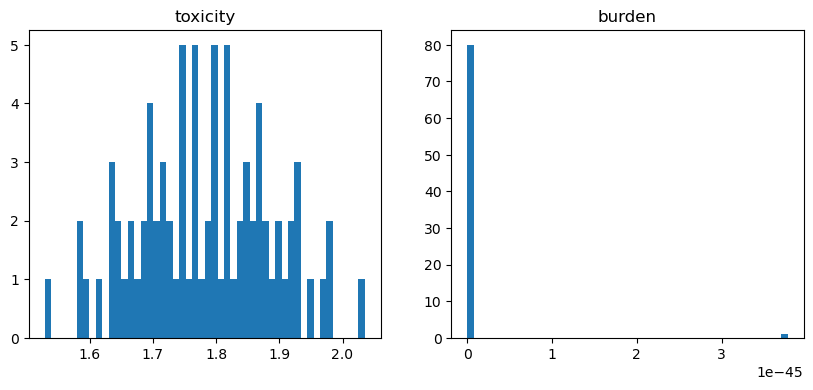

In [22]:
# plot two histograms for cost and benefit
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(df_sp["toxicity"], bins=50)
ax[0].set_title("toxicity");
ax[1].hist(df_sp["burden"], bins=50)
ax[1].set_title("burden");

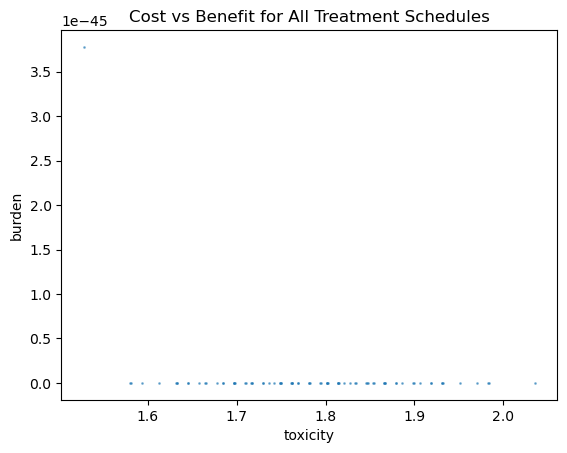

In [23]:
plt.scatter(df_sp["toxicity"], df_sp["burden"], s=1, alpha=0.5)

plt.xlabel("toxicity")
plt.ylabel("burden")
plt.title("Cost vs Benefit for All Treatment Schedules");